In [77]:
from pystan import StanModel

 # Begin Stan section
gwas_code = '''
data {
	// dimensions of the data
	int<lower = 0> N;
	int<lower = 0> P;

	// predictors (x) and target (y)
	matrix[N, P] x;
	vector[N] y;
}

parameters {
	// regression coefficients
	vector[P] beta;
    real sigma;

	// horseshoe prior parameters
	vector<lower = 0>[P] lambda;
	vector<lower = 0>[P] eta;
    real<lower = 0> tau;
}

model {
    // beta hierarchy
	tau ~ cauchy(0, 0.01);
	eta ~ cauchy(0, 0.01);
	lambda ~ cauchy(0, tau * eta);
	beta ~ normal(0, lambda);

    // sigma
    sigma ~ gamma(2, 0.5);
    
	// construct model 
	y ~ normal(x * beta, sigma);
}
'''
model = StanModel(model_code = gwas_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_46d2a416e3fcd40b9ef5ea977bcbb7d8 NOW.


In [78]:
# generate the GWAS data for testing the variationl bayes methods
import numpy as np
import pandas as pd
from math import exp

# data shape
p = 10000
true_p = 5
n = 500

maf = np.random.uniform(0.05, 0.5, p)
snps = np.empty(shape = (n, p))

for ind, f in np.ndenumerate(maf):
	snps[:, ind[0]] = np.random.binomial(2, f, n)

# normalize snps
snps = (snps - snps.mean(axis = 0)) / snps.std(axis = 0)

# generate genotypes
# select a subset to be in the true model
true_id = np.arange(1, true_p + 1)
true_snps = snps[:, true_id]
true_beta = np.random.normal(0, 6, len(true_id))
print(true_beta)

# create gene expression levels
true_snps = np.array(true_snps)
true_beta = np.array(true_beta)

geno = np.sum(true_snps * true_beta, axis = 1) + np.random.normal(0, 1)
print(geno)

geno = pd.DataFrame(geno)
snps = pd.DataFrame(snps)

# write the data in hdf5 format for faster reading
snps.to_hdf('data/snps.h5', 'data', mode='w', format='fixed')
geno.to_hdf('data/geno.h5', 'data', mode='w', format='fixed')

# save the true parameters
actual = pd.DataFrame({
	'snp_id': true_id
	,'beta': true_beta 
	})

actual.to_hdf('data/actual.h5', 'data', mode='w', format='fixed')


[-6.73298522  7.11008067  8.69290367 -1.61982938  4.2269587 ]
[  6.34629101 -11.46439306 -11.79678358 -30.34561716 -17.42623295
  19.56606509  19.56606509 -24.38377728  21.93269942 -22.01714294
  -0.61125332   6.34629101 -12.39257442 -17.42623295  -1.83982454
   1.12260063  -9.2401174    1.12260063  17.70471348  -4.50684874
   4.42240521  20.37173767  -1.2440337  -22.01714294   8.71292534
   3.78962483  -1.2440337   -3.61066803 -14.16341791  18.9332847
  21.29991903   8.71292534 -14.75920875  -4.83923926   5.71351062
 -16.19766173 -25.6123485    1.12260063 -21.71675308  -1.83982454
 -17.42623295  16.56665037  10.74716915 -27.97898283   6.34629101
  -0.61125332 -15.05959862   8.38053482  16.37661852 -15.05959862
  11.97574038 -24.38377728 -26.75041161  12.27613024 -26.75041161
  12.97144481 -22.01714294  -0.61125332 -11.46439306  11.97574038
  27.56214879 -24.38377728   8.38053482   6.34629101 -11.79678358
  14.34237471   3.97965668 -11.1640032  -11.46439306  -0.61125332
   0.08406125  

In [79]:
# read in previously generated data
geno = pd.read_hdf('data/geno.h5')
snps = pd.read_hdf('data/snps.h5')

geno = geno.values.flatten()
snps = snps.values

n = snps.shape[0]
p = snps.shape[1]

gwas_data = {
		'N': n
		,'P': p
		,'y': geno
		,'x': snps
	}

# ADVI using stochastic gradient descent
fit_advi = model.vb(data = gwas_data
	,output_samples = 1000
	,iter = 40000
	,eval_elbo = 250
	,tol_rel_obj = 0.01
	,algorithm = 'meanfield')

# read in the posterior draws for each parameter
param_file = fit_advi['args']['sample_file'].decode("utf-8")
advi_coef = pd.read_csv(param_file, skiprows = [0, 1, 2, 3, 5, 6])

# relabel to have the actual indicies of the betas after the split
betas = advi_coef.filter(like = "beta")
betas.columns = ["beta." + str(j) for j in range(0, p)]

# save coefficients in hdf5 format
betas.to_hdf('data/betas.h5', 'data', mode='w', format='fixed')

# save other estimates in hdf5
param = advi_coef.filter(regex = "^(?!beta).*$")
param.to_hdf('data/param.h5', 'data', mode='w', format='fixed')

print("Finished")

Finished


       beta  snp_id
0 -6.732985       1
1  7.110081       2
2  8.692904       3
3 -1.619829       4
4  4.226959       5


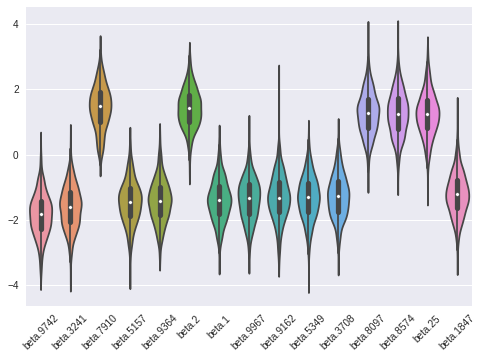

In [80]:
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats

raw_betas = pd.read_hdf('data/betas.h5')

n = raw_betas.shape[0]
p = raw_betas.shape[1]
true_p = 5

# print the actual values
actual = pd.read_hdf('data/actual.h5')
print(actual)

# print the actual values
# actual = pd.read_hdf('data/param.h5')

# unadjusted
betas = raw_betas.median(axis = 0)
top_betas = abs(betas).sort_values()[-15:][::-1]

beta_index = list(top_betas.index)
top_betas = raw_betas.filter(items = beta_index)

sb.violinplot(data = top_betas)
sb.plt.xticks(rotation = 45)
sb.plt.show()

# sb.regplot(actual.iloc[:, 0], betas[1:21])
# sb.plt.show()



In [3]:
# read in previously generated data
geno = pd.read_hdf('data/geno.h5')
snps = pd.read_hdf('data/snps.h5')

geno = geno.values.flatten()
snps = snps.values

n = snps.shape[0]
p = snps.shape[1]

gwas_data = {
		'N': n
		,'P': p
		,'y': geno
		,'x': snps
	}

# HMC 
fit_hmc = model.sampling(data = gwas_data
                         ,thin = 2
                         ,n_jobs = -1)
print(fit_hmc)


Inference for Stan model: anon_model_fd455faad699c416125c8269a7fa1dbe.
4 chains, each with iter=2000; warmup=1000; thin=5; 
post-warmup draws per chain=200, total post-warmup draws=800.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]    -1.9e-3    0.01   0.08  -0.19  -0.01-3.9e-3   0.01   0.21     55   1.06
beta[1]       2.66    1.95   2.76  -0.05 3.2e-3   1.48   4.87   7.85      2    5.7
beta[2]       8.83    2.46   3.48   1.25   5.45  10.35  11.14  13.03      2   4.82
beta[3]       5.78    4.11   5.82  -0.09-9.2e-4   4.93  11.43  13.35      2  11.72
beta[4]       5.77    4.14   5.85  -0.02 1.8e-3    4.8  10.81  13.68      2  12.15
beta[5]      10.19    4.19   5.92-2.8e-4   5.08   13.0   13.9  15.42      2   9.31
beta[6]      -0.12    0.08    0.2  -0.59  -0.27-1.7e-3 4.2e-3   0.04      7   3.18
beta[7]      -0.04    0.02   0.11  -0.34  -0.05-7.5e-3   0.02   0.14     24   1.25
beta[8]       0.03    0.02   0.13  -0.27-9.1e-3 4.6e-3   0.06   0.

In [31]:
log_name = 'logs/hmc_beta_dist_as_N(7, 1)'
with open(log_name, "w") as f:
    f.write(str(fit_hmc))